In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install waymo-open-dataset-tf-2.11.0
# pip install --upgrade Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import torch

from waymo_open_dataset.wdl_limited.sim_agents_metrics import metric_features
from waymo_open_dataset.wdl_limited.sim_agents_metrics import metrics

from waymo_open_dataset.protos import scenario_pb2
from waymo_open_dataset.protos import map_pb2
from waymo_open_dataset.protos import sim_agents_submission_pb2

from waymo_open_dataset.utils.sim_agents import submission_specs
from waymo_open_dataset.utils.sim_agents import test_utils as sim_agents_test_utils
from waymo_open_dataset.utils.sim_agents import visualizations
from waymo_open_dataset.utils import trajectory_utils

# Set matplotlib to jshtml so animations work with colab.
from matplotlib import rc
rc('animation', html='jshtml')

In [4]:
# for lane
TYPE_UNDEFINED = -1
TYPE_FREEWAY = 1
TYPE_SURFACE_STREET= 2
TYPE_BIKE_LANE= 3

# for roadline
TYPE_UNKNOWN = -1
TYPE_BROKEN_SINGLE_WHITE = 6
TYPE_SOLID_SINGLE_WHITE = 7
TYPE_SOLID_DOUBLE_WHITE = 8
TYPE_BROKEN_SINGLE_YELLOW = 9
TYPE_BROKEN_DOUBLE_YELLOW = 10
TYPE_SOLID_SINGLE_YELLOW = 11
TYPE_SOLID_DOUBLE_YELLOW = 12
TYPE_PASSING_DOUBLE_YELLOW = 13

# for roadedge
TYPE_ROAD_EDGE_BOUNDARY = 15
TYPE_ROAD_EDGE_MEDIAN = 16

# for stopsign
TYPE_STOP_SIGN = 17

# for crosswalk
TYPE_CROSSWALK = 18

# for speed bump
TYPE_SPEED_BUMP = 19

In [5]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/MtrAutobots/tensor_input_20230523002607.json', 'r') as file:
    jsondata_input = json.load(file)
# print(jsondata_input.keys())

with open('/content/drive/MyDrive/Colab Notebooks/MtrAutobots/tensor_output_20230523002610.json', 'r') as file:
    jsondata_output = json.load(file)
print(jsondata_output.keys())

dict_keys(['scenario_id', 'out_dists', 'mode_probs'])


In [26]:
tensor_dict_input = {
    'scenario_id': jsondata_input['scenario_id'],
    'obj_trajs': torch.Tensor(jsondata_input['obj_trajs']),
    'obj_trajs_mask':  torch.Tensor(jsondata_input['obj_trajs_mask']),
    'track_index_to_predict': torch.Tensor(jsondata_input['track_index_to_predict']).to(int),
    'obj_trajs_pos': torch.Tensor(jsondata_input['obj_trajs_pos']),
    'obj_trajs_last_pos': torch.Tensor(jsondata_input['obj_trajs_last_pos']),
    'obj_types': jsondata_input['obj_types'],
    'obj_ids': jsondata_input['obj_ids'],
    'center_objects_world': torch.Tensor(jsondata_input['center_objects_world']),
    'center_objects_type': jsondata_input['center_objects_type'],
    'obj_trajs_future_state': torch.Tensor(jsondata_input['obj_trajs_future_state']),
    'obj_trajs_future_mask': torch.Tensor(jsondata_input['obj_trajs_future_mask']),
    'center_gt_trajs': torch.Tensor(jsondata_input['center_gt_trajs']), #predictions
    'center_gt_trajs_mask': torch.Tensor(jsondata_input['center_gt_trajs_mask']),
    'center_gt_final_valid_idx': jsondata_input['center_gt_final_valid_idx'],
    'center_gt_trajs_src': torch.Tensor(jsondata_input['center_gt_trajs_src']),
    'map_polylines': torch.Tensor(jsondata_input['map_polylines']),
    'map_polylines_mask': torch.Tensor(jsondata_input['map_polylines_mask']),
    'map_polylines_center': torch.Tensor(jsondata_input['map_polylines_center'])

}

out_dists_ou = torch.Tensor(jsondata_output['out_dists'])
mode_probs_ou = torch.Tensor(jsondata_output['mode_probs'])


# Convert MTR waymo data to scenario format

In [21]:
from re import I
from google.protobuf.pyext._message import RepeatedScalarContainer


def convert_map_tensor_to_map_scenario(myscenario_map, tensor_dict, ego_idx = 0):

    map_polylines_in = tensor_dict['map_polylines']
    map_polylines_mask_in = tensor_dict['map_polylines_mask']

    for pol in range(768):
        pol_type = int(map_polylines_in[ego_idx,pol,0,6])
        map_feature = myscenario_map.map_features.add()
        map_feature.id = pol

        for pnt in range(20):
            if map_polylines_mask_in[ego_idx, pol, pnt]:
              x,y,z,_,_,_,_,_,_ =  map_polylines_in[ego_idx, pol, pnt,:]           
              polyline =  map_pb2.MapPoint()
              polyline.x = x
              polyline.y = y
              polyline.z = z

              if pol_type in [TYPE_SURFACE_STREET, TYPE_FREEWAY, TYPE_BIKE_LANE]:
                  lane = map_feature.lane
                  lane.type = pol_type
                  lane.polyline.append(polyline)

              # for roadline
              elif pol_type in [TYPE_BROKEN_SINGLE_WHITE, TYPE_SOLID_SINGLE_WHITE,
                            TYPE_SOLID_DOUBLE_WHITE, TYPE_BROKEN_SINGLE_YELLOW, 
                            TYPE_BROKEN_DOUBLE_YELLOW, TYPE_SOLID_SINGLE_YELLOW,
                            TYPE_SOLID_DOUBLE_YELLOW, TYPE_PASSING_DOUBLE_YELLOW]:

                  if pol_type == TYPE_BROKEN_SINGLE_WHITE:
                      local_pol_type = 1
                  elif pol_type == TYPE_SOLID_SINGLE_WHITE:
                      local_pol_type = 2
                  elif pol_type ==TYPE_SOLID_DOUBLE_WHITE:
                      local_pol_type = 3 
                  elif pol_type ==TYPE_BROKEN_SINGLE_YELLOW:
                      local_pol_type = 4
                  elif pol_type ==TYPE_BROKEN_DOUBLE_YELLOW:
                      local_pol_type = 5
                  elif pol_type ==TYPE_SOLID_SINGLE_YELLOW:
                      local_pol_type = 6
                  elif pol_type ==TYPE_SOLID_DOUBLE_YELLOW:
                      local_pol_type = 7
                  elif pol_type ==TYPE_PASSING_DOUBLE_YELLOW:
                      local_pol_type = 8

                  road_line = map_feature.road_line
                  road_line.type = local_pol_type
                  road_line.polyline.append(polyline)
                  
              # for roadedge
              elif pol_type in [TYPE_ROAD_EDGE_BOUNDARY, TYPE_ROAD_EDGE_MEDIAN]:
                  if pol_type == TYPE_ROAD_EDGE_BOUNDARY:
                      local_pol_type = 1
                  else:
                      local_pol_type = 2
                  road_edge = map_feature.road_edge
                  road_edge.type = local_pol_type
                  road_edge.polyline.append(polyline)

              # for stopsign
              elif pol_type == TYPE_STOP_SIGN:
                  stop_sign  = map_feature.stop_sign 
                  # stop_sign.type = pol_type
                  stop_sign.position.append(polyline)

              # for crosswalk
              elif pol_type == TYPE_CROSSWALK:
                  crosswalk = map_feature.crosswalk
                  crosswalk.polygon.append(polyline)

              # for speed bump
              elif pol_type == TYPE_SPEED_BUMP:
                  speed_bump  = map_feature.speed_bump
                  speed_bump.polygon.append(polyline)

    return myscenario_map  



def convert_tensor_to_scenario(tensor_dict, ego_agent=0):
    scenario = scenario_pb2.Scenario()

    tensor_dict_input = tensor_dict

    # SCENARIO ID
    # Assuming scenario_id is a list, select the first element as the scenario ID
    scenario.scenario_id = tensor_dict['scenario_id'][ego_agent] #STRING, size 1x16 lettres

    # TIMESTAMPS
    # Generate the timestamps based on the assumption of a 0.1-second step size
    timestamps_val = [0.1 * i for i in range(91)]
    scenario.timestamps_seconds.extend(timestamps_val) #class 'google.protobuf.pyext._message.RepeatedScalarContainer'

    # CURRENT TIME INDEX
    # Set the current_time_index between 0 and 90 based on the assumption of a 0.1-second step size
    scenario.current_time_index = 10

    # TRACKS
    # track = scenario_pb2.Track()
    obj_nb = 0 #later to change for every objects
    object_ids_one = []
    #for i in range(len(tensor_dict['obj_ids'])):

    for i in range(len(tensor_dict_input['track_index_to_predict'][:])):
        track = scenario_pb2.Track()
        object_ids_one = tensor_dict_input['obj_ids'][tensor_dict_input['track_index_to_predict'][i]]
        track.id = tensor_dict['obj_ids'][tensor_dict_input['track_index_to_predict'][i]]
        if (tensor_dict['obj_types'][i]== 'TYPE_UNSET'):
          track.object_type = 0
        elif (tensor_dict['obj_types'][i]== 'TYPE_VEHICLE'):
          track.object_type = 1
        elif (tensor_dict['obj_types'][i]== 'TYPE_PEDESTRIAN'):
          track.object_type = 2
        elif (tensor_dict['obj_types'][i]== 'TYPE_CYCLIST'):
          track.object_type = 3
        elif (tensor_dict['obj_types'][i]== 'TYPE_OTHER'):
          track.object_type = 4
        else:
          print('error on object type! ')
          print(tensor_dict['obj_types'][i])


        for ts in range(91):
            state = scenario_pb2.ObjectState()
            tensor_dict_input['center_gt_trajs_src']
            obj_traj = tensor_dict['center_gt_trajs_src']

            state.valid = int(obj_traj[i][ts][9])
            state.center_x = float(obj_traj[i][ts][0])
            state.center_y = float(obj_traj[i][ts][1])
            state.center_z = float(obj_traj[i][ts][2])
            state.length = float(obj_traj[i][ts][3])
            state.width = float(obj_traj[i][ts][4])
            state.height = float(obj_traj[i][ts][5])
            state.heading = float(obj_traj[i][ts][6])
            state.velocity_x = float(obj_traj[i][ts][7])
            state.velocity_y = float(obj_traj[i][ts][8])
            
            track.states.append(state)

        scenario.tracks.append(track)

    scenario.sdc_track_index = ego_agent # int(tensor_dict['track_index_to_predict'][0])

    scenario = convert_map_tensor_to_map_scenario(scenario, tensor_dict_input, ego_agent)

    return scenario

In [23]:
# scenario = convert_tensor_to_scenario(tensor_dict_input)

# Waymo helpers function

In [17]:
def joint_scene_from_states(
    states: tf.Tensor, object_ids: tf.Tensor
    ) -> sim_agents_submission_pb2.JointScene:
    # States shape: (num_objects, num_steps, 4).
    # Objects IDs shape: (num_objects,).
    states = states.numpy()
    simulated_trajectories = []
    for i_object in range(len(object_ids)):
      simulated_trajectories.append(sim_agents_submission_pb2.SimulatedTrajectory(
          center_x=states[i_object, :, 0], center_y=states[i_object, :, 1],
          center_z=states[i_object, :, 2], heading=states[i_object, :, 3],
          object_id=object_ids[i_object]
      ))
    return sim_agents_submission_pb2.JointScene(
        simulated_trajectories=simulated_trajectories)

# Now we can replicate this strategy to export all the parallel simulations.
def scenario_rollouts_from_states(
    scenario: scenario_pb2.Scenario,
    states: tf.Tensor, object_ids: tf.Tensor
    ) -> sim_agents_submission_pb2.ScenarioRollouts:
    # States shape: (num_rollouts, num_objects, num_steps, 4).
    # Objects IDs shape: (num_objects,).
    joint_scenes = []
    for i_rollout in range(states.shape[0]):
      joint_scenes.append(joint_scene_from_states(states[i_rollout], object_ids))
    return sim_agents_submission_pb2.ScenarioRollouts(
        # Note: remember to include the Scenario ID in the proto message.
        joint_scenes=joint_scenes, scenario_id=scenario.scenario_id)

In [18]:
import math

def compute_heading(prev_x, prev_y, curr_x, curr_y):
    delta_x = curr_x - prev_x
    delta_y = curr_y - prev_y

    # Calculate the heading in radians
    heading_rad = math.atan2(delta_y, delta_x)

    # Adjust heading to the range [-pi, pi]
    if heading_rad > math.pi:
        heading_rad -= 2 * math.pi
    elif heading_rad < -math.pi:
        heading_rad += 2 * math.pi

    return heading_rad

def get_waymo_metrics_info(vector):
  # Change the vector dimension of [K,B,T,F] with F = 4 to F = 6
  # intital F : x,y,vx,vy
  # new F : x,y,z,heading,vx,vy
  z = 0.90
  K,B,T,F = vector.shape
  heading = torch.zeros((K,B,T,2))
  for sim in range(K):
    for obj in range(B):
      for i in range(T-1):
        heading[sim,obj,i,1] = compute_heading(vector[sim][obj][i][0], vector[sim][obj][i][1], vector[sim][obj][i+1][0], vector[sim][obj][i+1][1])
        heading[sim,obj,i,0] = z
      heading[sim,obj,T-1,1] = heading[sim,obj,T-2,1]
      heading[sim,obj,T-1,0] = z
  final_tensor = torch.cat((vector[:,:,:,:2],heading[:,:,:,:],vector[:,:,:,2:]),dim=-1)
  
  return final_tensor

# Compute Sim agents metric on the waymo data

In [65]:
myscenario = convert_tensor_to_scenario(tensor_dict_input)

In [34]:
# preprocessing data for sim agents metric
track_index_to_predict_in = tensor_dict_input['track_index_to_predict']
obj_ids_in = tensor_dict_input['obj_ids']

out_dists = np.transpose(out_dists_ou[:32,:,:,:4],(0,2,1,3))



In [38]:
output_prediction = get_waymo_metrics_info(out_dists)

In [39]:
out_dists.shape

torch.Size([32, 7, 80, 4])

In [40]:
output_prediction.shape

torch.Size([32, 7, 80, 6])

In [42]:

eager_tensor = tf.convert_to_tensor(output_prediction[:,:,:,:4])
print(out_dists.shape)

print(type(eager_tensor))

center_id = [obj_ids_in[i] for i in track_index_to_predict_in]
center_id = np.array(center_id)

torch.Size([32, 7, 80, 4])
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [43]:
# function preparation for submission
joint_scene = joint_scene_from_states(eager_tensor[0, :, :, :], center_id)
submission_specs.validate_joint_scene(joint_scene, myscenario)

scenario_rollouts = scenario_rollouts_from_states(
    myscenario, eager_tensor, center_id)

submission_specs.validate_scenario_rollouts(scenario_rollouts, myscenario)

single_scene_features = metric_features.compute_metric_features(
myscenario, joint_scene)

In [162]:
# Compute the features for a single JointScene.
single_scene_features = metric_features.compute_metric_features(
    myscenario, joint_scene)

# Visualization

In [45]:
from waymo_open_dataset.utils.sim_agents import visualizations

In [154]:
myscenario = convert_tensor_to_scenario(tensor_dict_input)

In [147]:
track.states[t]

center_x: 10.58984375
center_y: 373.5849609375
center_z: -87.75162506103516
length: 4.877461910247803
width: 2.14194917678833
height: 1.5577911138534546
heading: -5.638131141662598
velocity_x: 3.955078125
velocity_y: 2.51953125
valid: true

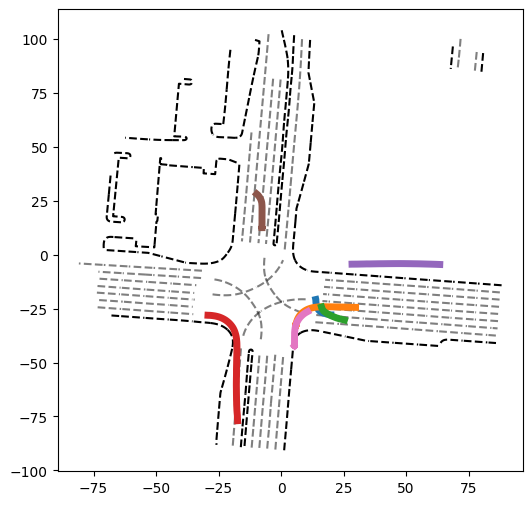

In [161]:
import numpy as np

myscenario = convert_tensor_to_scenario(tensor_dict_input)
# Visualize scenario.
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

visualizations.add_map(ax, myscenario)

def plot_track_trajectory(track: scenario_pb2.Track) -> None:
  valids = np.array([state.valid for state in track.states])
  if np.any(valids):
    x = np.array([state.center_x for state in track.states])
    y = np.array([state.center_y for state in track.states])
    ax.plot(x[valids], y[valids], linewidth=5)

for track in myscenario.tracks:
    angle = -0.2
    for t in range(91):
        track.states[t].center_x -= 8670 
        track.states[t].center_y -= 11135 
        #track.states[t].center_x = track.states[t].center_x * np.cos(angle) -  track.states[t].center_y * np.sin(angle)
        #track.states[t].center_y = track.states[t].center_x * np.cos(angle) + track.states[t].center_y * np.sin(angle)
        #track.states[t].heading  -= 3.14 * 2
    # print('track.states[0].center_x',track.states[0].center_x)
    # print('track.states[0].center_y',track.states[0].center_y)
    plot_track_trajectory(track)

plt.show();

Evaluated objects: [2821]
Evaluated objects in features: [2821]
Are all agents valid: True
ADE: 81.58598327636719

============ KINEMATIC FEATURES ============


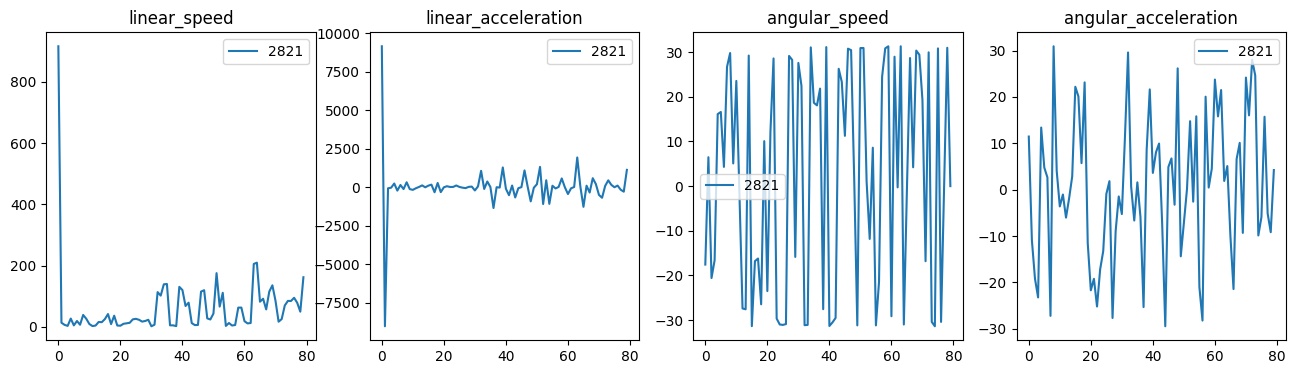


============ INTERACTIVE FEATURES ============
Colliding objects: [ True]


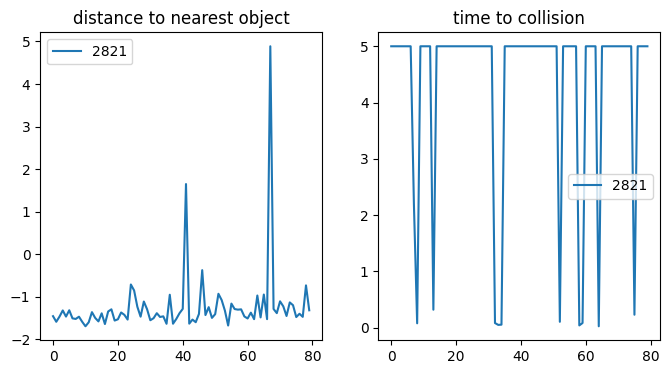


============ MAP-BASED FEATURES ============
Offroad objects: [ True]


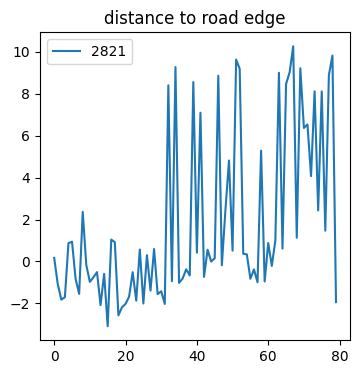

In [163]:
# These features will be computed only for the `tracks_to_predict` objects.
print(f'Evaluated objects: {submission_specs.get_evaluation_sim_agent_ids(scenario)}')
# This will also match single_scene_features.object_ids
print(f'Evaluated objects in features: {single_scene_features.object_id}')

# Features contain a validity flag, which for simulated rollouts must be always
# True, because we are requiring the sim agents to be always valid when replaced.
print(f'Are all agents valid: {tf.reduce_all(single_scene_features.valid)}')

# ============ FEATURES ============ 
# Average displacement feature. This corresponds to ADE in the BP challenges,
# here is used just as a comparison (it's not actually included in the final score).
# Shape: (1, n_objects).
print(f'ADE: {tf.reduce_mean(single_scene_features.average_displacement_error)}')

# Kinematic features.
print('\n============ KINEMATIC FEATURES ============')
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i_object in range(len(single_scene_features.object_id)):
  _object_id = single_scene_features.object_id[i_object].numpy()
  axes[0].plot(single_scene_features.linear_speed[0, i_object, :], label=str(_object_id))
  axes[1].plot(single_scene_features.linear_acceleration[0, i_object, :], label=str(_object_id))
  axes[2].plot(single_scene_features.angular_speed[0, i_object, :], label=str(_object_id))
  axes[3].plot(single_scene_features.angular_acceleration[0, i_object, :], label=str(_object_id))


TITLES = ['linear_speed', 'linear_acceleration', 'angular_speed', 'angular_acceleration']
for ax, title in zip(axes, TITLES):
  ax.legend()
  ax.set_title(title)
plt.show()

# Interactive features.
print('\n============ INTERACTIVE FEATURES ============')
print(f'Colliding objects: {single_scene_features.collision_indication[0]}')
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i_object in range(len(single_scene_features.object_id)):
  _object_id = single_scene_features.object_id[i_object].numpy()
  axes[0].plot(single_scene_features.distance_to_nearest_object[0, i_object, :], label=str(_object_id))
  axes[1].plot(single_scene_features.time_to_collision[0, i_object, :], label=str(_object_id))

TITLES = ['distance to nearest object', 'time to collision']
for ax, title in zip(axes, TITLES):
  ax.legend()
  ax.set_title(title)
plt.show();

# Map-based features.
print('\n============ MAP-BASED FEATURES ============')
print(f'Offroad objects: {single_scene_features.offroad_indication[0]}')
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
for i_object in range(len(single_scene_features.object_id)):
  _object_id = single_scene_features.object_id[i_object].numpy()
  axes.plot(single_scene_features.distance_to_road_edge[0, i_object, :], label=str(_object_id))
axes.legend()
axes.set_title('distance to road edge')

plt.show();